<font face = 'arial' color = 'navy' size = 12pt> Project 3 - Hassan Koroma </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Regression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# validation
from sklearn.model_selection import cross_val_score # does validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split as tts, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# scaling & labels
from sklearn.preprocessing import StandardScaler as SS, PolynomialFeatures as PF, LabelEncoder

# other metrics
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


plt.rc('font', size=16)
plt.rc('axes', titlesize=16)

<font color = 'blue' size = 6pt> Question 1 - GridSearchCV for SVM Regresssion </font>

Import the <b>concrete strength dataset</b>. Use <b>GridSearchCV</b> to find the <b>best epsilon</b> (within the range 1-10) <b>and C</b> (within the range 1-5) values for a Support Vector Machine regression when you <b>predict the concrete strength</b> with a <b>polynomial kernel of degree 2</b>.

In [2]:
data = pd.read_csv('data/concrete.csv')
data.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
x = data.loc[:, 'cement':'age'].values
y = data['strength'].values

In [4]:
%%time
model = SVR(kernel = 'poly', degree = 2)
params = [{'epsilon':np.arange(1,10,0.25),'C':np.arange(1,5,0.25)}]
gs = GridSearchCV(estimator=model,cv=10,scoring='neg_mean_squared_error',param_grid=params)
gs_results = gs.fit(x,y)
print(gs_results.best_params_)
print('The mean square error is: ', np.abs(gs_results.best_score_))

{'C': 4.75, 'epsilon': 1.25}
The mean square error is:  154.43831417883086
CPU times: user 3min 4s, sys: 831 ms, total: 3min 5s
Wall time: 3min 6s


<font color = 'blue' size = 6pt> Question 2 - Classification </font>

Import the <b>Electrical Grid dataset</b>. Write your validation function based on </b>stratified 10-Fold cross-validations</b> for testing the models and record (for each classifier) the <b>ROC curves and the AUC for detecting the class of 1</b> (meaning "unstable"). For each testing fold, <b>extract the recall and precision values from the classification report</b> and decide which model performed better based on the fold averages of ‘recall’ and ‘precision’ values.


In [6]:
df = pd.read_csv('data/ElectricalGridData.csv')
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [7]:
labels = LabelEncoder()
y = labels.fit_transform(df['stabf'])

In [8]:
x = df.loc[:, 'tau1':'g4'].values

In [10]:
def validation(x, y, classifier):
    n_samples, n_features = x.shape

    cv = StratifiedKFold(n_splits=10,shuffle = True,random_state=310)

    precisions_0 = []
    recalls_0 = []
    precisions_1 = []
    recalls_1 = []

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(8,8))
    for i, (train, test) in enumerate(cv.split(x, y)):
        classifier.fit(x[train], y[train])

        report = classification_report(y[test], classifier.predict(x[test]), output_dict=True)

        precision_0 = report.get('0').get('precision')
        recall_0 = report.get('0').get('recall')
        precisions_0.append(precision_0)
        recalls_0.append(recall_0)

        precision_1 = report.get('1').get('precision')
        recall_1 = report.get('1').get('recall')
        precisions_1.append(precision_1)
        recalls_1.append(recall_1)

        viz = plot_roc_curve(classifier, x[test], y[test],
                            name='ROC fold {}'.format(i),
                            alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    print(f'Avg Stable Precision: {np.mean(precisions_0)}; Avg Stable Recall: {np.mean(recalls_0)}')
    print(f'Avg Unstable Precision: {np.mean(precisions_1)}; Avg Unstable Recall: {np.mean(recalls_1)}')

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver Operating Characteristic (ROC) Application")
    ax.legend(loc="lower right")
    plt.show()

In [11]:
svc1 = SVC(kernel='poly', degree=2, probability=True,random_state=310)

Avg Stable Precision: 0.8533294936016043; Avg Stable Recall: 0.8450276243093923
Avg Unstable Precision: 0.9125949134543896; Avg Unstable Recall: 0.9173981191222571


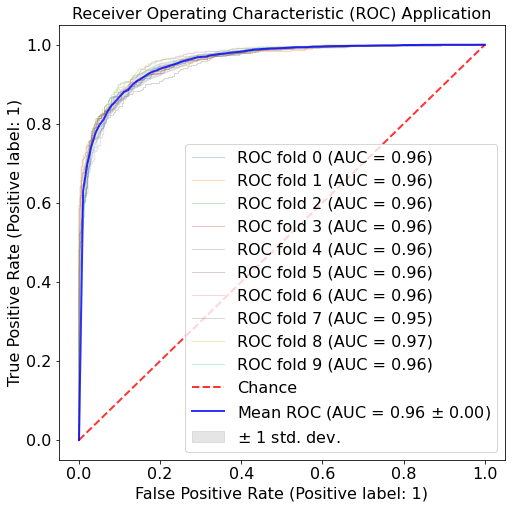

In [12]:
validation(x, y, svc1)

In [13]:
svc2 = SVC(kernel='rbf', probability=True, random_state=310)

Avg Stable Precision: 0.8762049007301652; Avg Stable Recall: 0.8088397790055248
Avg Unstable Precision: 0.8960971777980354; Avg Unstable Recall: 0.9351097178683385


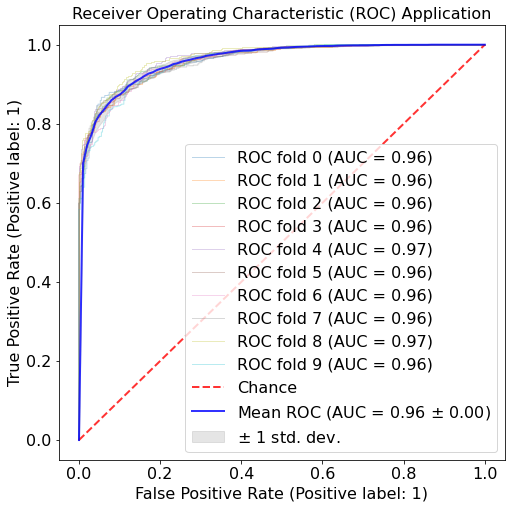

In [14]:
validation(x, y, svc2)

In [15]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

Avg Stable Precision: 0.7333605442574203; Avg Stable Recall: 0.6585635359116022
Avg Unstable Precision: 0.8170840000491836; Avg Unstable Recall: 0.8642633228840125


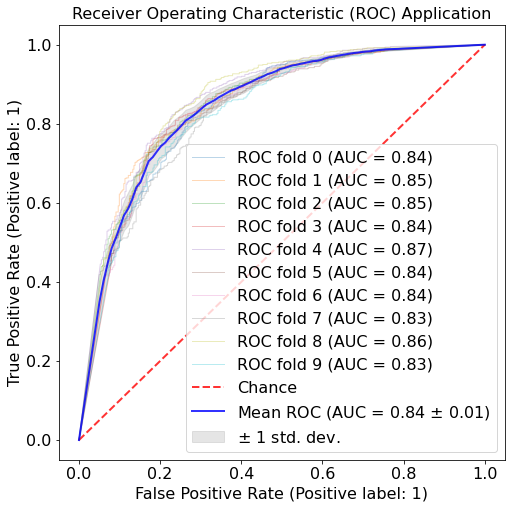

In [16]:
validation(x, y, knn)

In [17]:
rfc = RandomForestClassifier(n_estimators=100,max_depth=5)

Avg Stable Precision: 0.9235067937919311; Avg Stable Recall: 0.6406077348066297
Avg Unstable Precision: 0.8263047772915832; Avg Unstable Recall: 0.9697492163009404


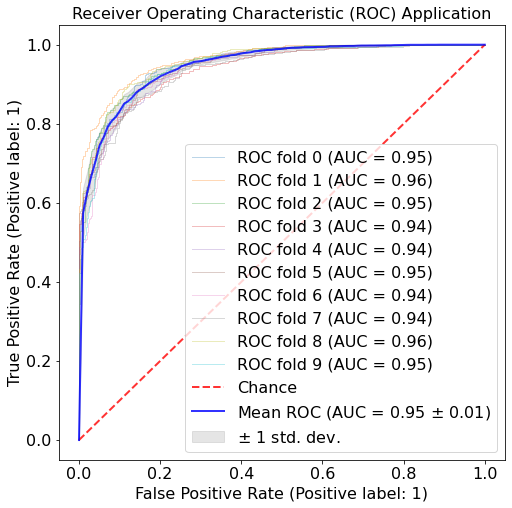

In [18]:
validation(x, y, rfc)

<font color = 'blue' size = 6pt> Question 3 - Simmulated Annealing </font>

Re-write the simmulated annealing code (developed in-class) to accomodate a 2-D grid search optimization and apply it to determine the optimal hyperparameters for ElasticNet (such as alpha and l1_ratio) and apply it to the "housing" dataset. The variables chosen should be the same as the ones we worked on in-class.

In [19]:
housing = pd.read_csv('data/housing.csv')
housing.head()

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001


In [20]:
X = housing.drop('river', axis = 1).loc[:, 'crime':'lstat'].values
y = housing['cmedv'].values

In [21]:
Xscaled = SS().fit_transform(X)

In [22]:
MIN_ALPHA = 0.001
MAX_ALPHA = 2

MIN_L1RATIO = 0.001
MAX_L1RATIO = 1

STEP_SIZE = 1     # Std of gaussian steps
COOLING = 0.98   # T_{n+1} = T_{n}*COOLING, i.e. geometric cooling

In [23]:
def cost_function(model):
    k_fold = cross_val_score(estimator=model,X=Xscaled,y=y,cv=10,scoring='neg_mean_squared_error')
    return -k_fold.mean()
def random_start():
    alpha = np.random.random()*(MAX_ALPHA-MIN_ALPHA) + MIN_ALPHA
    return alpha
def random_start2():
    l1_ratio = np.random.random()*(MAX_L1RATIO-MIN_L1RATIO) + MIN_L1RATIO
    return l1_ratio
def random_neighbour(alpha, l1_ratio, T):
    delta_alpha = np.random.normal()*STEP_SIZE*T
    new_alpha = min(MAX_ALPHA, max(MIN_ALPHA, alpha+delta_alpha))
    delta_l1_ratio = np.random.normal()*STEP_SIZE*T
    new_l1_ratio = min(MAX_L1RATIO, max(MIN_L1RATIO, l1_ratio+delta_l1_ratio))
    return new_alpha, new_l1_ratio
def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        return 1
    else:
        p = np.exp(-(new_cost - cost) / temperature)
        return p
def locate_min(a):
    smallest = min(a)
    return smallest, [index for index, element in enumerate(a) if smallest == element]

def annealing(alpha0 = random_start(), l1_ratio0 = random_start2()):
    alpha = alpha0
    l1_ratio = l1_ratio0
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=50000)
    
    # Compute the cost function (in this case, 1-accuracy)
    cost = cost_function(model)
    
    # Keep lists of results, start with the current
    states, states2, costs = [alpha], [l1_ratio], [cost]
    T = 1
    while T > 1e-10:
        new_alpha, new_l1_ratio = random_neighbour(alpha, l1_ratio, T)
        model = ElasticNet(alpha=new_alpha, l1_ratio=new_l1_ratio, max_iter=50000)
        new_cost = cost_function(model)
        if acceptance_probability(cost, new_cost, T) > np.random.random():
            cost = new_cost
            alpha = new_alpha
            l1_ratio = new_l1_ratio
            states.append(alpha)
            states2.append(l1_ratio)
            costs.append(cost)
        T = T*COOLING
    return model, states, states2, costs

In [24]:
%%time
model, states, states2, costs = annealing()

lowest_cost, best_states = locate_min(costs)
print('Lowest cost function value: ' + str(lowest_cost))
print('Best alpha value(s):')
print([states[idx] for idx in best_states])
print('Best l1_ratio value(s):')
print([states2[idx] for idx in best_states])

Lowest cost function value: 31.575118200126713
Best alpha value(s):
[0.15379170438201378]
Best l1_ratio value(s):
[0.001]
CPU times: user 17.8 s, sys: 266 ms, total: 18.1 s
Wall time: 18.3 s
